In [98]:
from sklearn.linear_model import LinearRegression  # 선형회귀
from sklearn.preprocessing import PolynomialFeatures # 다항특성을 만들어주는 라이브러리
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 표시 해결
# 한글설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # windows 사용자
# matplotlib.rcParams['font.family'] = 'AppleGothic Gothic' # Mac사용자
matplotlib.rcParams['font.size'] = '10' # 글자크기

In [99]:
# 타이타닉의 생존자 분류 모델을 구현하시오.
# target : survived
# data : 그외

# data로 사용할 feature
# pclass: 승객등급
# survived : 생존1/죽음0
# sibsp: 함께 탑승한 형제 또는 배우자 수
# parch : 함께 탑승한 부모 또는 자녀 수
# ticket : 티켓 번호
# cabin : 선실번호
# fare : 승객 지불 요금
# embarked : 탑승 장소

# 분류 : 로지스틱,랜덤포레스트, 결정트리

In [100]:
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')
df_train.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0,NaN,S,NaN,"Cornwall / Akron, OH"


name, cabin의 데이터를 추가

In [101]:
df_train = df_train.drop(['ticket','body','home.dest'],axis=1)
df_train

df_test = df_test.drop(['ticket','body','home.dest'],axis=1)
df_test.head(3)


,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,embarked
0,3,0,"Rekic, Mr. Tido",male,38.0,0,0,7.8958,NaN,S
1,2,1,"Phillips, Miss. Alice Frances Louisa",female,21.0,0,1,21.0000,NaN,S
2,2,0,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,27.0000,NaN,S


In [102]:
# 결측치 처리
replace_mean = df_train[df_train['age']>0]['age'].mean()

# 결측치에 넣을 평균값 - train,test set 모두 적용
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embarked : 결측값  - 데이터 2개
# 데이터 중 가장 많이 나온 결과의 값을 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

In [103]:
whole_df = pd.concat([df_train,df_test])
whole_df.shape   # 총 1309개의 데이터

(1309, 10)

In [104]:
# cabin 처리
# cabin : 선실 번호
whole_df['cabin'].value_counts().head()

cabin
C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
B96 B98            4
Name: count, dtype: int64

In [105]:
# 결측치 데이터를 X로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('X')
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 392
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   name      1309 non-null   object 
 3   sex       1309 non-null   object 
 4   age       1309 non-null   float64
 5   sibsp     1309 non-null   int64  
 6   parch     1309 non-null   int64  
 7   fare      1309 non-null   float64
 8   cabin     1309 non-null   object 
 9   embarked  1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 112.5+ KB


In [106]:
# cabin의 데이터 앞 첫글자를 저장
whole_df['cabin'] = whole_df['cabin'].str[0]
whole_df['cabin'].value_counts()

cabin
X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [107]:
# G : 5, T : 1 
# 항목 중 데이터 개수가 적은 것은 항목을 줄이기 위해 X로 귀속
whole_df['cabin'] = whole_df['cabin'].replace({'G':'X','T':'X'})

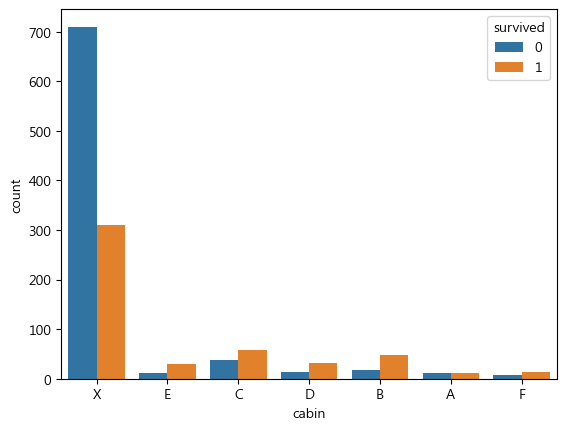

In [118]:
import seaborn as sns
ax = sns.countplot(x='cabin',hue='survived',data=whole_df)

In [109]:
# name feature 전처리
whole_df['name'].head()

0    Mellinger, Miss. Madeleine Violet
1                    Wells, Miss. Joan
2       Duran y More, Miss. Florentina
3                   Scanlan, Mr. James
4         Bradley, Miss. Bridget Delia
Name: name, dtype: object

In [110]:
# ','와 '.'를 기준으로 split
whole_df['name'] = whole_df['name'].str.split(',').str[1].str.split('.').str[0].str.strip()

In [111]:
whole_df['name'].unique()

array(['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms',
       'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major',
       'Don', 'Capt'], dtype=object)

In [112]:
whole_df['name'].value_counts()

name
Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Jonkheer          1
Don               1
Lady              1
Mme               1
Dona              1
the Countess      1
Sir               1
Capt              1
Name: count, dtype: int64

In [113]:
# 호칭에 따른 사회적 지위를 파악
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
              'D': ['Mr', 'Don'], # 남성을 나타냅니다.
              'E': ['Master'], # 젊은남성을 나타냅니다.
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.
grade_dict.items()

dict_items([('A', ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir']), ('B', ['Ms', 'Mme', 'Mrs', 'Dona']), ('C', ['Jonkheer', 'the Countess']), ('D', ['Mr', 'Don']), ('E', ['Master']), ('F', ['Miss', 'Mlle', 'Lady'])])

In [114]:
# 함수를 적용해서 name 데이터 적용
def give_grade(x):
    for key,value in grade_dict.items():
        for title in value:
            if x == title:
                return key

In [115]:
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))

In [116]:
whole_df['name']

0      F
1      F
2      F
3      D
4      F
      ..
388    D
389    B
390    D
391    D
392    F
Name: name, Length: 1309, dtype: object

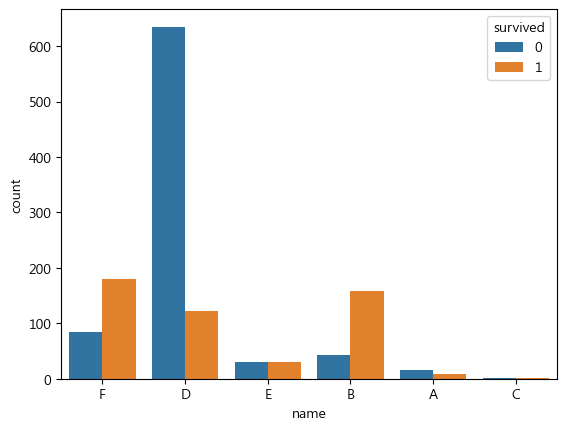

In [117]:
ax = sns.countplot(x='name',hue='survived',data=whole_df)

name 내 성별,지위에 따른 생존도 t-test 검정 해보자! 

In [119]:
# 원핫인코딩
train_index_num = len(df_train)
train_index_num

whole_df_encoded = pd.get_dummies(whole_df)

In [120]:
# train,test 세트 분리
# whole_df_encode.loc[:,whole_df_encode.columns != 'survived']
datas = whole_df_encoded.drop({'survived'},axis=1)
target = whole_df_encoded['survived']

# train : 916
train_input = datas.iloc[:train_index_num]
train_target = target.iloc[:train_index_num]

# test : 393
test_input = datas.iloc[train_index_num:]
test_target = target.iloc[train_index_num:]

In [122]:
from sklearn.linear_model import LogisticRegression

# 데이터 훈련시키기
# 로지스틱 회귀
lr = LogisticRegression(random_state=42)
lr.fit(train_input,train_target)

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [123]:
print(lr.score(train_input,train_target))
print(lr.score(test_input,test_target))

0.8155021834061136
0.7938931297709924
